### Import packages

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns

### Load and inspect the data
- Load the Excel file into a DataFrame and inspect it for data quality.
- Remove rows where latitude (Lat) or longitude (Log) values are 0 in the dataset


In [215]:
# Load the Excel file
file_path = "/Users/mayar/Desktop/MIT/Research_Fellow/ENERGY_SENSING/DATA/2022_vitals.xlsx"
df = pd.read_excel(file_path)

# Drop rows where Lat or Log is 0
df = df[(df['Lat'] != 0) & (df['Log'] != 0)]

# Save the cleaned data back to Excel (optional)
output_path = "/Users/mayar/Desktop/MIT/Research_Fellow/ENERGY_SENSING/DATA/2022_vitals_cleaned.xlsx"
df.to_excel(output_path, index=False)

# Print the cleaned data preview
print(df.head())


   Unnamed: 0                  deviceID   Timestamp        Lat        Log  \
0           1  32002a000a504e5354303420  1657558677  59.342079  18.047274   
1           1  32002a000a504e5354303420  1657558707  59.342102  18.047491   
2           1  32002a000a504e5354303420  1657558737  59.342049  18.047604   
3           1  32002a000a504e5354303420  1657558767  59.341831  18.046106   
4           1  32002a000a504e5354303420  1657558797  59.340618  18.041285   

   SOC_batt  temp_batt  volatge_batt  voltage_particle  current_batt  \
0        71       21.9          3.95              3.93           123   
1        71       21.6          3.95              3.93           119   
2        71       21.6          3.95              3.93           117   
3        71       21.4          3.95              3.93           104   
4        71       21.4          3.94              3.93           124   

   isCharging  isCharginS  isCharged  Temp_int  Hum_int  solar_current  \
0           0           1     

### Convert Timestamps and Create a Spatial Grid
- Convert the Timestamp column from Unix format to human-readable datetime.
- Group the GPS data into a spatial grid for coverage analysis.

In [216]:
# Convert Unix timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Spatial Resolution, here: 0.001-degree resolution
spatial_resolution=0.001

# Create a spatial grid 
df['Lat_Grid'] = (df['Lat'] // spatial_resolution) * spatial_resolution
df['Log_Grid'] = (df['Log'] // spatial_resolution) * spatial_resolution

# Temporal Resolution, 1-minute intervals
temporal_resolution = '1T'  

# Create temporal bins
df['Time_Bin'] = df['Timestamp'].dt.floor(temporal_resolution)

# Check the modified DataFrame
#print(df)


/var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ipykernel_1684/2213688677.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['Time_Bin'] = df['Timestamp'].dt.floor(temporal_resolution)


### Initial Analysis
#### Check Data Distribution
- Before plotting, inspect the distribution of the Count column to confirm the skew. If the Count values have a large range (e.g., some counts are much higher than others), you can apply a logarithmic scale to the color mapping. This makes smaller variations more distinguishable.


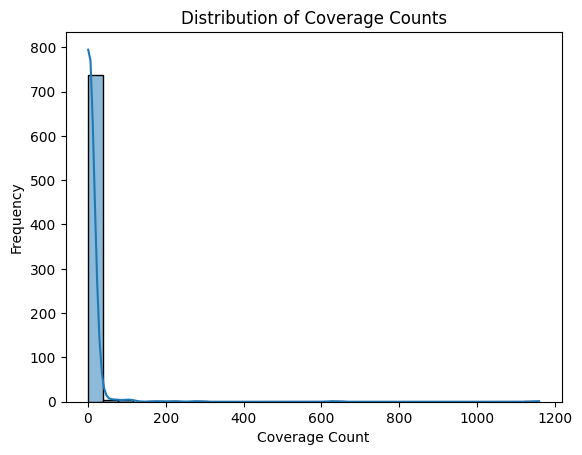

In [217]:
sns.histplot(coverage['Count'], bins=30, kde=True)
plt.title('Distribution of Coverage Counts')
plt.xlabel('Coverage Count')
plt.ylabel('Frequency')
plt.show()


### Plot
- Analyze sensor coverage by aggregating the spatial grid.
- Visualize coverage heatmaps. To better visualize the data, apply logarithmic scaling to the color values. This will compress the range of large values and expand the smaller values for more differentiation in color. 
- We apply Fractional Power Scaling: Highlights smaller values significantly, making subtle differences more visible. We Raise the log-transformed values to a fractional power $ \log(x+1)^{0.5} $. This amplifies small differences while keeping the general scale.
##### Note:
- If \( x = 0 \), the standard `np.log(x)` would result in an error because the logarithm of 0 is undefined. 
`np.log1p(x)` handles this safely by adding \( 1 \) to the input before computing the logarithm, ensuring it works for non-negative numbers, including \( 0 \).
- The square root further compresses the range of the values.  
It emphasizes smaller differences by reducing the impact of large values. For example:  
$\log(x+1)^{0.5} $ grows slower than $\log(x+1)$ as $\ x $ increases.

**This transformation is particularly useful for skewed data, for `Count` values, where:**

- Most data points are small.
- A few extreme values (outliers) dominate.




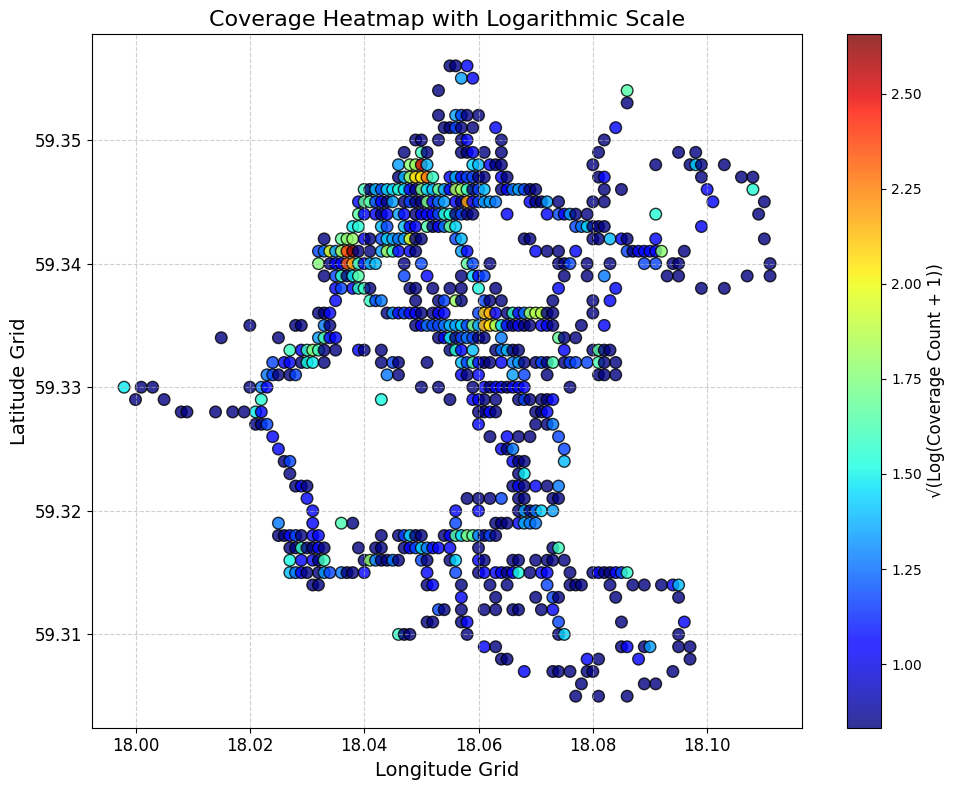

In [218]:
# Group by spatial grid and count occurrences
coverage = df.groupby(['Lat_Grid', 'Log_Grid']).size().reset_index(name='Count')

# Set up the figure size
plt.figure(figsize=(10, 8))

# Apply logarithmic scaling
log_scaled_values = np.log1p(coverage['Count'])**0.5 

# Apply logarithmic scaling to color values
sc = plt.scatter(
    coverage['Log_Grid'], 
    coverage['Lat_Grid'], 
    c=log_scaled_values,  
    cmap='jet', 
    s=70, 
    edgecolor='k', 
    alpha=0.8
)

# Add a color bar with the original scale in the label
cbar = plt.colorbar(sc)
cbar.set_label('√(Log(Coverage Count + 1))', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Add labels and title with improved font sizes
plt.xlabel('Longitude Grid', fontsize=14)
plt.ylabel('Latitude Grid', fontsize=14)
plt.title('Coverage Heatmap with Logarithmic Scale', fontsize=16)

# Add grid lines for reference
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Improve tick sizes for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


### Analyse the Temporal Sampling

In [219]:
# Calculate time difference in seconds between consecutive rows
df['Delta_t'] = df['Timestamp'].diff().dt.total_seconds()  

# Define an expected interval in seconds (e.g., 60 seconds)
expected_interval = 60

# Count the total number of occurrences of measurements
tot_count = df['Delta_t'].count()
print(f"Number of values: {tot_count}")

# Count the number of occurrences of low frequency measurements
highf_count = (df['Delta_t'] > expected_interval).sum()
print(f"Number of values higher than 60sec: {highf_count}")

# Count the number of occurrences of 0.0
zero_count = (df['Timestamp'].diff().dt.total_seconds() == 0.0).sum()
print(f"Number of values equal to 0.0sec: {zero_count}")


Number of values: 5844
Number of values higher than 60sec: 143
Number of values equal to 0.0sec: 1125


### Energy and Coverage Model Preparation
- Create columns to represent:

    - Whether a street segment is already covered.
    - Battery state changes.

##### Filtering out Outliners

In [220]:
# Calculate time difference in seconds between consecutive rows
df['Delta_t'] = df['Timestamp'].diff().dt.total_seconds()  

# Define a threshold for acceptable intervals (e.g., 60 seconds)
acceptable_threshold = 60   # in seconds

# Filter out rows with large Delta_t
df = df[df['Delta_t'] <= acceptable_threshold]

# Drop rows with Delta_t equal to zero
df = df[df['Delta_t'] > 0]

# Reset the index
df = df.reset_index(drop=True)

The battery capacity is 10,000 mAh, so SOC_Change (calculated from current and time) must be converted into a percentage of the total capacity before being added to `SOC_batt`.

### SOC Update Formula:
$SOC_{new} = SOC_{old} + \frac{\Delta SOC_{mAh}}{C_{batt}} \times 100$ 

and 

$\Delta SOC_{mAh} = -1 \times I_{batt} \times \Delta t$ (mAh change based on current and time)

Where:
- $SOC_{old}$ is $SOC_{batt}$
- $\ I_{batt} $: Net current (`current_batt`) in mA (positive for consumption, negative for storage).
- $\ \Delta t $: Time difference in hours between consecutive rows.
- $\ C_{batt} $: Battery capacity in mAh (10,000 mAh).


In [221]:
# Battery capacity in mAh
battery_capacity = 10000

# Calculate time difference in hours between consecutive rows
df['Delta_t'] = df['Delta_t'] / 3600  # Time difference in hours

# Calculate SOC change (in %) using the corrected formula
df['SOC_Change'] = (-1 * df['current_batt'] * df['Delta_t'] / battery_capacity) * 100

# Set SOC_Change to 0 when SOC is saturated
df.loc[df['SOC_batt'] >= 90, 'SOC_Change'] = 0

# Ensure SOC values are capped between 0 and 100
df['SOC_batt'] = df['SOC_batt'] + df['SOC_Change']
df['SOC_batt'] = df['SOC_batt'].clip(lower=0, upper=100)

# Assume that is >90%, charging is stopped
df.loc[df['SOC_batt'] >= 90, 'SOC_Change'] = 0

# Preview the updated DataFrame
print(df[['Timestamp', 'Lat', 'Log', 'SOC_batt', 'SOC_Change', 'Delta_t', 'current_batt']])

               Timestamp        Lat        Log   SOC_batt  SOC_Change  \
0    2022-07-11 16:58:27  59.342102  18.047491  70.990083   -0.009917   
1    2022-07-11 16:58:57  59.342049  18.047604  70.990250   -0.009750   
2    2022-07-11 16:59:27  59.341831  18.046106  70.991333   -0.008667   
3    2022-07-11 16:59:57  59.340618  18.041285  70.989667   -0.010333   
4    2022-07-11 17:00:26  59.339722  18.037241  70.996294   -0.003706   
...                  ...        ...        ...        ...         ...   
4565 2022-09-03 20:20:08  59.341297  18.038725  57.986911   -0.013089   
4566 2022-09-03 20:20:09  59.341297  18.038725  56.999608   -0.000392   
4567 2022-09-05 08:35:29  59.341297  18.038725  54.988167   -0.011833   
4568 2022-09-05 08:35:59  59.341297  18.038725  54.988167   -0.011833   
4569 2022-09-05 08:36:03  59.341297  18.038725  53.998433   -0.001567   

       Delta_t  current_batt  
0     0.008333           119  
1     0.008333           117  
2     0.008333           104  

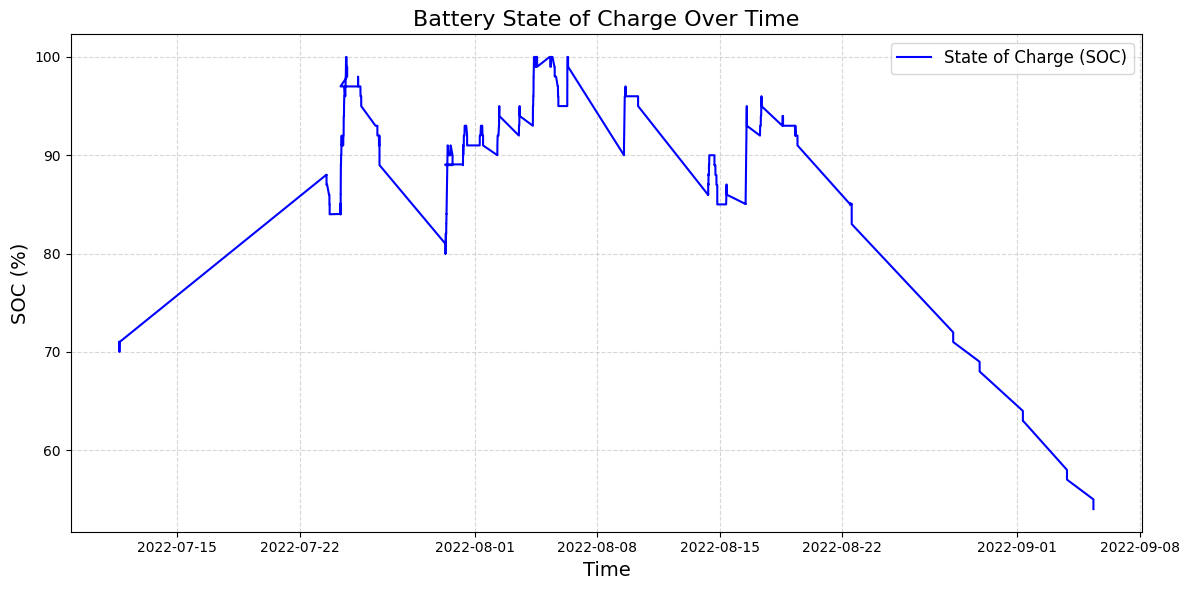

In [222]:
# Plot SOC over time
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['SOC_batt'], label='State of Charge (SOC)', color='blue', linewidth=1.5)
plt.xlabel('Time', fontsize=14)
plt.ylabel('SOC (%)', fontsize=14)
plt.title('Battery State of Charge Over Time', fontsize=16)
plt.grid(alpha=0.5, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [223]:
# Filter rows where SOC is increasing or decreasing
increasing = df[df['SOC_Change'] > 0]
decreasing = df[df['SOC_Change'] < 0]

print(f"Number of times SOC increases: {len(increasing)}")
print(f"Number of times SOC decreases: {len(decreasing)}")


Number of times SOC increases: 381
Number of times SOC decreases: 808


In [224]:
# Mark covered segments (spatio-temporal condition)
df['Is_Covered'] = df.duplicated(subset=['Lat_Grid', 'Log_Grid', 'Time_Bin'], keep='first')

# Preview the updated DataFrame
print(df.head())

   Unnamed: 0                  deviceID           Timestamp        Lat  \
0           1  32002a000a504e5354303420 2022-07-11 16:58:27  59.342102   
1           1  32002a000a504e5354303420 2022-07-11 16:58:57  59.342049   
2           1  32002a000a504e5354303420 2022-07-11 16:59:27  59.341831   
3           1  32002a000a504e5354303420 2022-07-11 16:59:57  59.340618   
4           1  32002a000a504e5354303420 2022-07-11 17:00:26  59.339722   

         Log   SOC_batt  temp_batt  volatge_batt  voltage_particle  \
0  18.047491  70.990083       21.6          3.95              3.93   
1  18.047604  70.990250       21.6          3.95              3.93   
2  18.046106  70.991333       21.4          3.95              3.93   
3  18.041285  70.989667       21.4          3.94              3.93   
4  18.037241  70.996294       21.1          3.95              3.95   

   current_batt  ...  Hum_int  solar_current  Cellular signal strenght  \
0           119  ...     59.4           4.63                

In [ ]:
def energy_aware_switch(row):
    if row['Is_Covered'] and row['SOC_batt'] > 20:
        return 'OFF'
    elif not row['Is_Covered'] and row['SOC_batt'] > 10:
        return 'ON'
    else:
        return 'IDLE'

df['Sensor_State'] = df.apply(energy_aware_switch, axis=1)

df['Cumulative_Spatial_Coverage'] = (~df['Is_Covered']).cumsum()
temporal_coverage = df.groupby(['Lat_Grid', 'Log_Grid', 'Time_Bin']).size().reset_index(name='Frequency')

high_coverage_cells = temporal_coverage[temporal_coverage['Frequency'] > 2]
high_coverage_cells
df['Sens

0        ON
1       OFF
2        ON
3        ON
4        ON
       ... 
4565     ON
4566    OFF
4567     ON
4568    OFF
4569     ON
Name: Sensor_State, Length: 4570, dtype: object

In [210]:
# Initialize cumulative coverage and energy tracking
df['Cumulative_Coverage'] = 0
df['Average_SOC'] = 0

# Initialize variables
cumulative_coverage = set()  # To store unique covered grid cells
soc_list = []  # To store SOC levels

# Simulate over the data
for idx, row in df.iterrows():
    # Update cumulative coverage if sensor is ON
    if row['Sensor_State'] == 'ON':
        cumulative_coverage.add((row['Lat_Grid'], row['Log_Grid']))

    # Update SOC tracking
    soc_list.append(row['SOC_batt'])

    # Update DataFrame
    df.at[idx, 'Cumulative_Coverage'] = len(cumulative_coverage)
    df.at[idx, 'Average_SOC'] = sum(soc_list) / len(soc_list)

# Preview results
print(df[['Timestamp', 'Cumulative_Coverage', 'Average_SOC']])


/var/folders/rw/5mn6h4bn5z18wdnwdjlb_tjr0000gn/T/ipykernel_1684/2115075431.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '70.99990083333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'Average_SOC'] = sum(soc_list) / len(soc_list)


               Timestamp  Cumulative_Coverage  Average_SOC
0    2022-07-11 16:58:27                    1    70.999901
1    2022-07-11 16:58:57                    1    70.999902
2    2022-07-11 16:59:27                    2    70.999906
3    2022-07-11 16:59:57                    3    70.999903
4    2022-07-11 17:00:26                    4    70.999915
...                  ...                  ...          ...
4565 2022-09-03 20:20:08                  749    92.412185
4566 2022-09-03 20:20:09                  749    92.404431
4567 2022-09-05 08:35:29                  749    92.396243
4568 2022-09-05 08:35:59                  749    92.388058
4569 2022-09-05 08:36:03                  749    92.379658

[4570 rows x 3 columns]


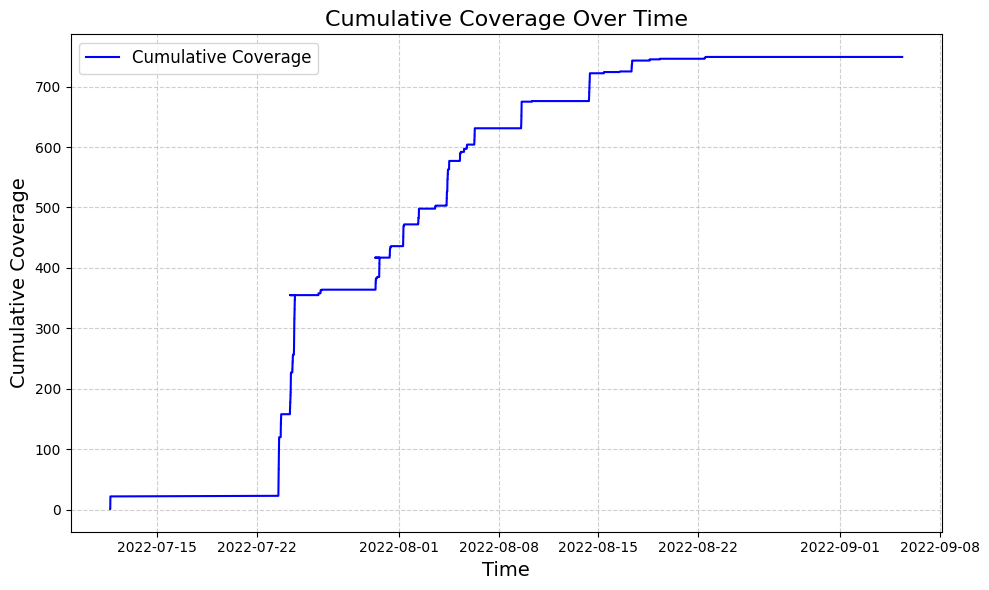

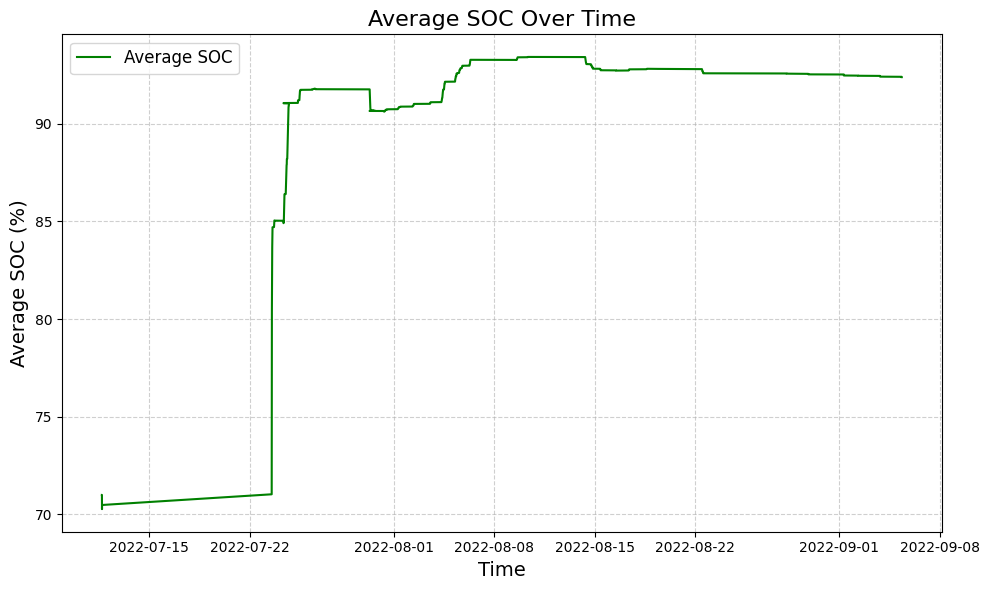

In [211]:
# Plot cumulative coverage over time
plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp'], df['Cumulative_Coverage'], label='Cumulative Coverage', color='b')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Cumulative Coverage', fontsize=14)
plt.title('Cumulative Coverage Over Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot average SOC over time
plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp'], df['Average_SOC'], label='Average SOC', color='g')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Average SOC (%)', fontsize=14)
plt.title('Average SOC Over Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [212]:
# Baseline: All sensors ON
df['Baseline_Coverage'] = 0
df['Baseline_SOC'] = 0.0

# Initialize variables
baseline_coverage = set()
baseline_soc_list = []

for idx, row in df.iterrows():
    # Assume sensors are always ON
    baseline_coverage.add((row['Lat_Grid'], row['Log_Grid']))
    baseline_soc_list.append(row['SOC_batt'])

    # Update DataFrame
    df.at[idx, 'Baseline_Coverage'] = len(baseline_coverage)
    df.at[idx, 'Baseline_SOC'] = sum(baseline_soc_list) / len(baseline_soc_list)

# Compare cumulative coverage and SOC
print(df[['Timestamp', 'Cumulative_Coverage', 'Baseline_Coverage', 'Average_SOC', 'Baseline_SOC']])


               Timestamp  Cumulative_Coverage  Baseline_Coverage  Average_SOC  \
0    2022-07-11 16:58:27                    1                  1    70.999901   
1    2022-07-11 16:58:57                    1                  1    70.999902   
2    2022-07-11 16:59:27                    2                  2    70.999906   
3    2022-07-11 16:59:57                    3                  3    70.999903   
4    2022-07-11 17:00:26                    4                  4    70.999915   
...                  ...                  ...                ...          ...   
4565 2022-09-03 20:20:08                  749                749    92.412185   
4566 2022-09-03 20:20:09                  749                749    92.404431   
4567 2022-09-05 08:35:29                  749                749    92.396243   
4568 2022-09-05 08:35:59                  749                749    92.388058   
4569 2022-09-05 08:36:03                  749                749    92.379658   

      Baseline_SOC  
0     

In [213]:
# Total cumulative coverage
energy_aware_coverage = df['Cumulative_Coverage'].iloc[-1]
baseline_coverage = df['Baseline_Coverage'].iloc[-1]

# Average SOC
energy_aware_avg_soc = df['Average_SOC'].mean()
baseline_avg_soc = df['Baseline_SOC'].mean()

# Improvement metrics
coverage_improvement = (energy_aware_coverage - baseline_coverage) / baseline_coverage * 100
soc_savings = (baseline_avg_soc - energy_aware_avg_soc) / baseline_avg_soc * 100

# Print results
print(f"Energy-Aware Total Coverage: {energy_aware_coverage}")
print(f"Baseline Total Coverage: {baseline_coverage}")
print(f"Coverage Improvement: {coverage_improvement:.2f}%")
print(f"Energy Savings: {soc_savings:.2f}%")


Energy-Aware Total Coverage: 749
Baseline Total Coverage: 749
Coverage Improvement: 0.00%
Energy Savings: 0.00%
